In [1]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as sdist

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("TP1_data.csv", index_col=0)

In [4]:
df.head()

,attribut1,attribut2,attribut3,attribut4,classe
id1,38.0,33.0,10.0,19.0,0
id2,38.2,23.4,17.0,16.6,0
id3,33.0,24.0,19.0,23.0,0
id4,31.0,21.0,29.0,16.0,0
id5,37.0,27.0,24.0,12.0,0


In [5]:
df.describe()

,attribut1,attribut2,attribut3,attribut4,classe
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,49.793220,23.486441,9.594915,14.557627,0.915254
std,10.490782,3.531995,8.174992,4.057994,0.815542
min,28.700000,16.500000,0.000000,3.700000,0.000000
25%,40.850000,21.050000,2.400000,12.000000,0.000000
50%,49.000000,23.300000,9.000000,15.100000,1.000000
75%,59.200000,25.100000,13.000000,16.950000,2.000000
max,68.500000,33.000000,29.100000,23.000000,2.000000


In [6]:
scaler = StandardScaler()
features = df.iloc[:, :-1]
scaler.fit(features)

normalized_df = pd.DataFrame(scaler.transform(features), columns=['attribut1', 'attribut2', 'attribut3', 'attribut4'])
normalized_df['classe'] = df['classe'].values

#normalized_df = df   # NO NORMALISATION

normalized_df_c0 = normalized_df[normalized_df.classe==0].drop("classe",axis=1)
normalized_df_c1 = normalized_df[normalized_df.classe==1].drop("classe",axis=1)
normalized_df_c2 = normalized_df[normalized_df.classe==2].drop("classe",axis=1)


X = normalized_df[['attribut1', 'attribut2', 'attribut3', 'attribut4']]
target = normalized_df['classe'].values
classes = np.unique(target)

# 1. Représentation des données:

### Visualisation

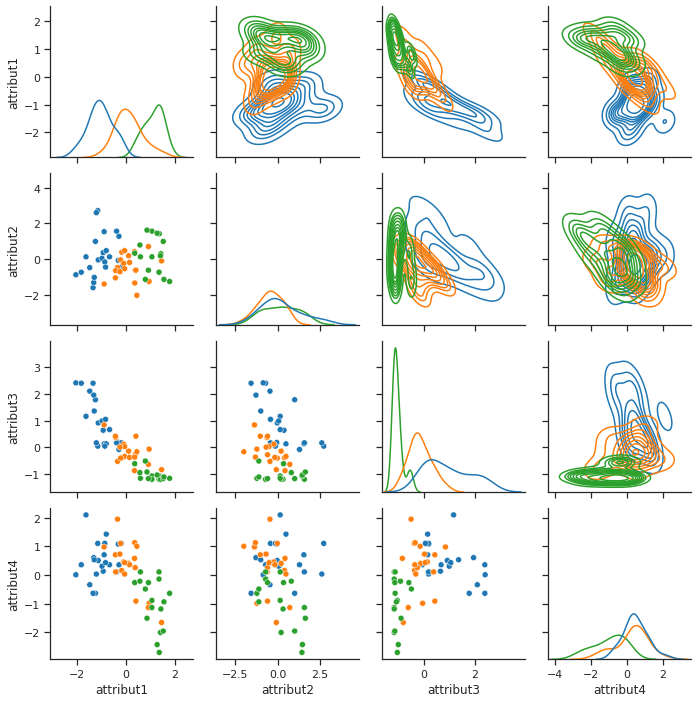

In [7]:
sns.set(style="ticks")


graph2 = sns.PairGrid(normalized_df, hue="classe", palette="tab10")
graph2.map_lower(sns.scatterplot)
graph2.map_upper(sns.kdeplot)
graph2.map_diag(sns.kdeplot)

# graph3 = sns.pairplot(normalized_df, hue="classe", diag_kind="hist", corner=True)
# graph3.map_lower(sns.kdeplot, levels=4, color=".2")   # kde: Kernel Density Estimate


### T-SNE Visualisation

In [8]:
tsne = TSNE()
X_tsne = tsne.fit_transform(X)

Text(0, 0.5, 'tsne axe 2')

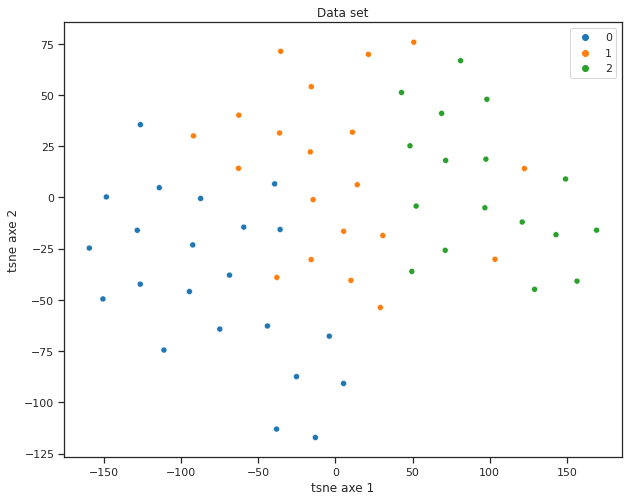

In [9]:
fig, axes = plt.subplots(1, 1,figsize=(10,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=target, palette='tab10')
axes.set_title('Data set')
axes.set_xlabel("tsne axe 1")
axes.set_ylabel("tsne axe 2")

### Corrélation

<AxesSubplot:>

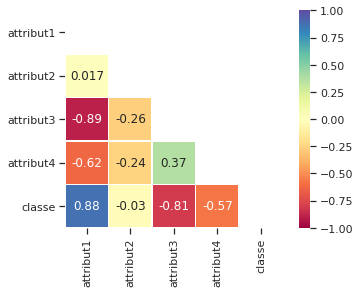

In [10]:
corr_df = normalized_df.corr(method='pearson')
corr_c0_df = normalized_df_c0.corr(method='pearson')
corr_c1_df = normalized_df_c1.corr(method='pearson')
corr_c2_df = normalized_df_c2.corr(method='pearson')


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap='Spectral', vmax=1, vmin=-1, center=0, annot=True,
            square=True, linewidths=.5)


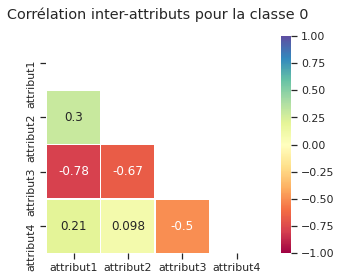

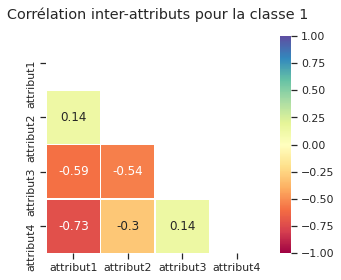

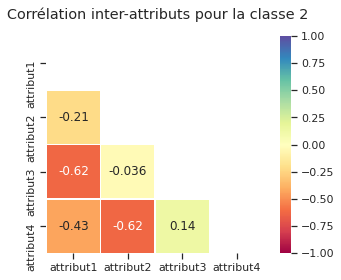

In [11]:
correlations = [corr_c0_df, corr_c1_df, corr_c2_df]
for _index, _corr in enumerate(correlations):
    mask = np.triu(np.ones_like(_corr, dtype=bool))
    plt.figure(_index)
    plt.suptitle("Corrélation inter-attributs pour la classe %i" %_index)
    sns.heatmap(_corr,  mask=mask, vmax=1, vmin=-1, center=0,
            square=True, cmap='Spectral', annot=True, linewidth=0.5)
    plt.show()

## (a)

Suite à la visualisation, ainsi que l'analyse de corrélation de l'ensemble de données, nous constatons qu'il serait favorable de procéder à une analyse des composantes principales.

Effectivement, nous constatons que l'attribut1 ainsi que l'attribut3 semble corrélé peu importe la classe sous analyse.

De plus, nous remarquons que l'_attribut2_ présente une très faible corrélation (proche de 0) par rapport à l'ensemble de classes.  (PAS CERTAIN)

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


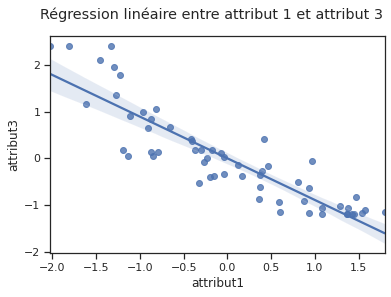

In [12]:
sns.regplot(normalized_df.loc[:, 'attribut1'], normalized_df.loc[:, 'attribut3'])
plt.suptitle("Régression linéaire entre attribut 1 et attribut 3")
plt.show()


### Analyse ACP

In [13]:
X.head()

,attribut1,attribut2,attribut3,attribut4
0,-1.133800,2.716658,0.049977,1.104118
1,-1.114572,-0.024684,0.913597,0.507616
2,-1.614500,0.146650,1.160346,2.098288
3,-1.806780,-0.710019,2.394089,0.358491
4,-1.229940,1.003320,1.777217,-0.635679


In [42]:
pca_full = PCA(n_components=X.shape[1])
pca_full.fit(X)
X_pca_full = pca_full.transform(X)

print("PCA(4) explained variance: ", pca_full.explained_variance_ratio_, "which sum up to: ",
      np.round(pca_full.explained_variance_ratio_.sum()*100, 2), "%")

PCA(4) explained variance:  [0.58532927 0.24909152 0.16140426 0.00417495] which sum up to:  100.0 %


On constate que les variables _attribut1_, _attribut2_, _attribut3_ expliquent plus de 99% de la variance.

In [25]:
def distanceToCentroidErrors(features, target, classes, distance_fct=sdist.euclidean, VI=None):
    """
    inputs
    ------
    features: numpy array
    target: numpy array
    classes: numpy array representing the unique classes
    
    outputs
    -------
    errors_df: pandas dataframe
    """
    centroids = []
    centroids_dict = {}
    for _classe in classes:
        target_mask = target == _classe
        features_masked = features[target_mask]
        centroid = features_masked.mean(axis=0)
        centroids.append(centroid)
        centroids_dict[_classe] = centroid
        
    centroid_targets = []
    for _feature in features:
        if VI is None:
            centroid_targets.append(np.argmin([distance_fct(_feature, centroid) for centroid in centroids]))
        else:
            centroid_targets.append(np.argmin([distance_fct(_feature, centroid, VI) for centroid in centroids]))

    errors_df = pd.DataFrame({'actual_classes': target, 'reduction_classes': centroid_targets})
    errors_df['divergence'] = (errors_df['actual_classes'] != errors_df['reduction_classes']).astype(int)
    
    return errors_df, centroids_dict

## (b)

# VISUALISATION PCA(2) ?!?

### 2CP Comparaison

In [40]:
pca_2 = PCA(n_components=2)
pca_2.fit(X)
X_pca_2 = pca_2.transform(X)
print("PCA(2) explained variance: ", pca_2.explained_variance_ratio_, "which sum up to: ",
      np.round(pca_2.explained_variance_ratio_.sum()*100, 2), "%")

errors_df, centroids_dict = distanceToCentroidErrors(X_pca_2, target, classes, distance_fct=sdist.euclidean)
errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("2CP - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))

PCA(2) explained variance:  [0.58532927 0.24909152] which sum up to:  83.44 %
2CP - Il y a un total de 6 erreurs sur  59, soit: 0.102 %.


### 3CP Comparaison

In [41]:
pca_3 = PCA(n_components=3)
pca_3.fit(X)
X_pca_3 = pca_3.transform(X)
print("PCA(3) explained variance: ", pca_3.explained_variance_ratio_, "which sum up to: ",
      np.round(pca_3.explained_variance_ratio_.sum()*100, 2), "%")

errors_df, centroids_dict = distanceToCentroidErrors(X_pca_3, target, classes, distance_fct=sdist.euclidean)
errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("3CP - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))


PCA(3) explained variance:  [0.58532927 0.24909152 0.16140426] which sum up to:  99.58 %
3CP - Il y a un total de 7 erreurs sur  59, soit: 0.119 %.


# 2. Mesure de distance:

## UTILISATION DE PCA(3) : semble le plus legit (a confirmer) ^^^^^^^^^^^

In [43]:
X_pca = X_pca_3

### Distance Manhattan

In [46]:
errors_df, centroids_dict = distanceToCentroidErrors(X_pca, target, classes, distance_fct=sdist.cityblock)
errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("3CP - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))

3CP - Il y a un total de 10 erreurs sur  59, soit: 0.169 %.


### Distance Euclidienne

In [44]:
errors_df, centroids_dict = distanceToCentroidErrors(X_pca, target, classes, distance_fct=sdist.euclidean)
errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("3CP - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))


3CP - Il y a un total de 7 erreurs sur  59, soit: 0.119 %.


### Distance Mahalanobis

In [62]:
cov_matrix = np.cov(X_pca.T)
inverted_cov_matrix = np.linalg.inv(cov_matrix)

In [65]:
cov_matrix.shape

(3, 3)

In [63]:
errors_df, centroids_dict = distanceToCentroidErrors(X_pca, target, classes, distance_fct=sdist.mahalanobis, VI=inverted_cov_matrix)
errors_pct = np.round(errors_df['divergence'].sum() / errors_df.shape[0], 3)
print("3CP - Il y a un total de {0} erreurs sur  {1}, soit: {2} %.".format(
    errors_df['divergence'].sum(), errors_df.shape[0], errors_pct))

3CP - Il y a un total de 12 erreurs sur  59, soit: 0.203 %.
